# Stratification of COVID Models

In [1]:
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using DisplayAs, Markdown

## Define basic epidemiology model

Define the type system for infectious disease models

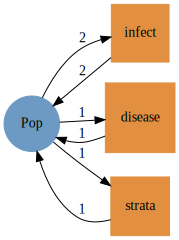

In [2]:
const infectious_ontology = LabelledPetriNet(
  [:Pop],
  :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
  :disease => (:Pop => :Pop),
  :strata => (:Pop => :Pop)
)

to_graphviz(infectious_ontology)

Define a simple SIRD model with reflexive transitions typed as `:strata` to indicate which states can be stratified
Here we add reflexive transitions to the susceptible, infected, and recovered populations but we leave out the dead
population because they cannote do things such as get vaccinated or travel between regions.

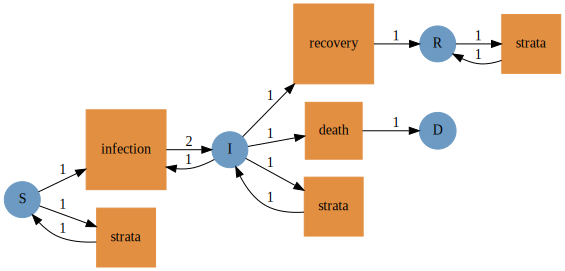

In [3]:
sird_uwd = @relation (S,I,R,D) where (S::Pop, I::Pop, R::Pop, D::Pop) begin
  infect(S, I, I, I)
  disease(I, R)
  disease(I, D)
end

sird_model = oapply_typed(infectious_ontology, sird_uwd, [:infection, :recovery, :death])
sird_model = add_reflexives(sird_model, [[:strata], [:strata], [:strata], []], infectious_ontology)

to_graphviz(dom(sird_model))

## Define intervention models

### Masking model

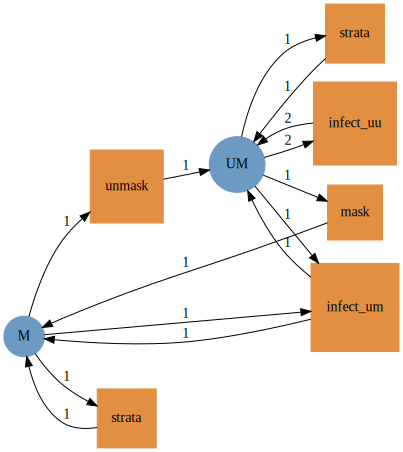

In [4]:
masking_uwd = @relation (M,UM) where (M::Pop, UM::Pop) begin
  disease(M, UM)
  disease(UM, M)
  infect(M, UM, M, UM)
  infect(UM, UM, UM, UM)
end
mask_model = oapply_typed(infectious_ontology, masking_uwd, [:unmask, :mask, :infect_um, :infect_uu])
mask_model = add_reflexives(mask_model, [[:strata], [:strata]], infectious_ontology)

to_graphviz(dom(mask_model))

Stratify our SIRD model on this masking model to get a model of SIRD with masking:

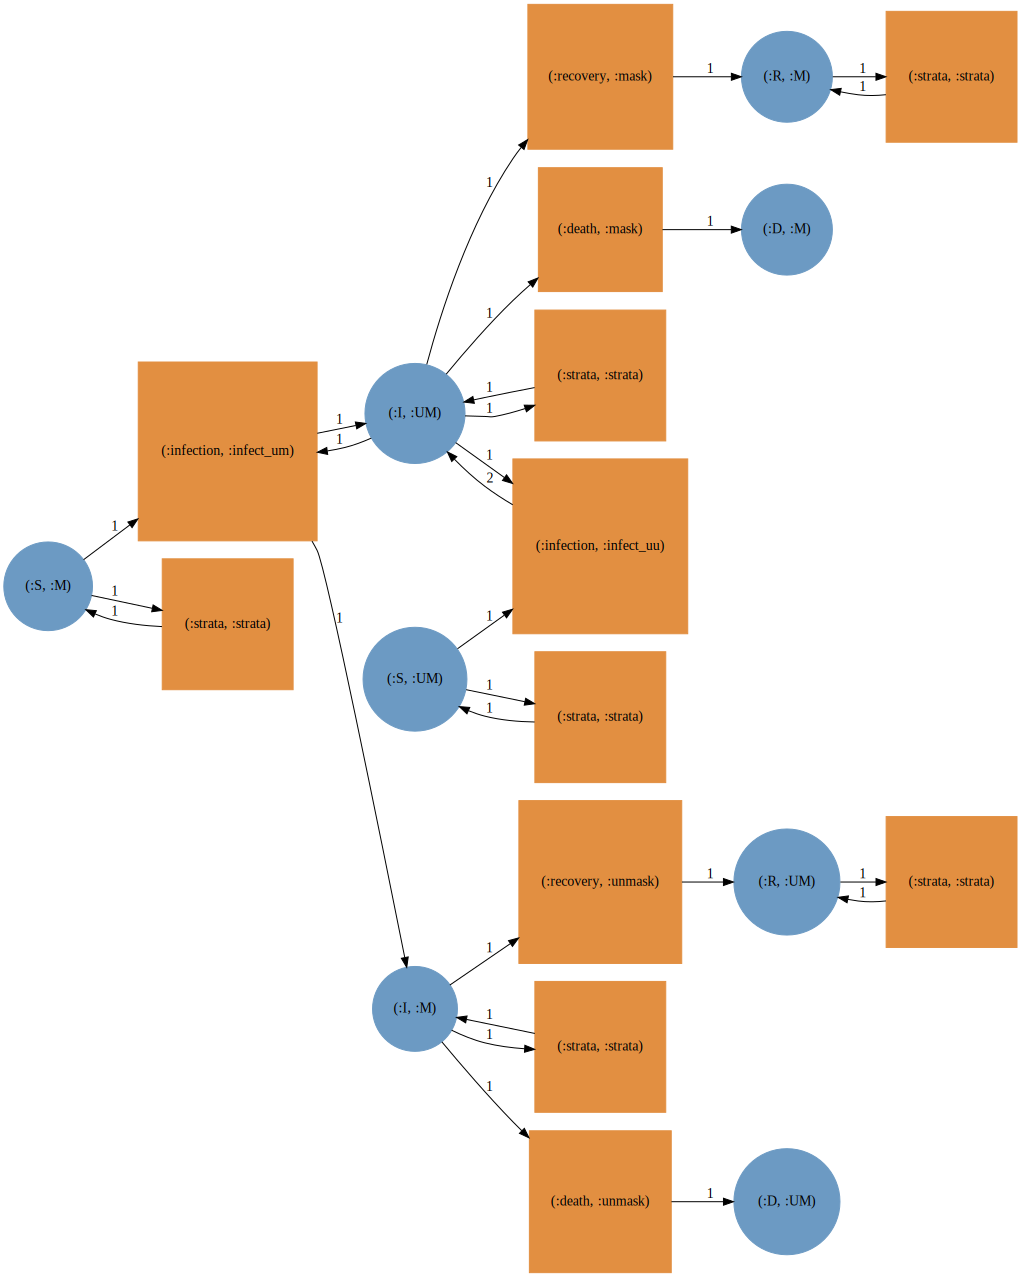

In [5]:
typed_product(sird_model, mask_model) |> dom |> to_graphviz

### Vaccine model

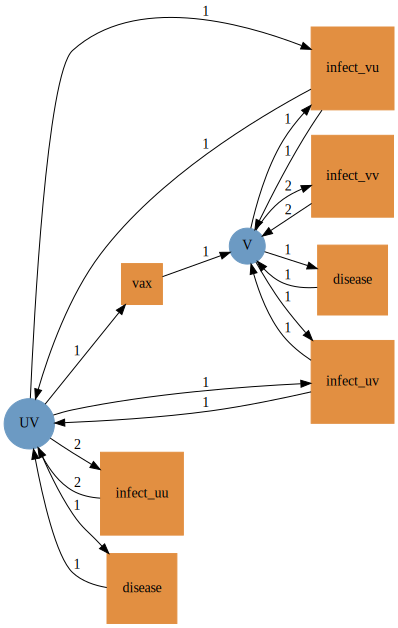

In [6]:
vax_uwd = @relation (UV,V) where (UV::Pop, V::Pop) begin
  strata(UV, V)
  infect(V, V, V, V)
  infect(V, UV, V, UV)
  infect(UV, V, UV, V)
  infect(UV, UV, UV, UV)
end
vax_model = oapply_typed(infectious_ontology, vax_uwd, [:vax, :infect_vv, :infect_uv, :infect_vu, :infect_uu])
vax_model = add_reflexives(vax_model, [[:disease], [:disease]], infectious_ontology)

to_graphviz(dom(vax_model))

Stratify our SIRD model on this vaccine model to get a model of SIRD with a vaccination rate:

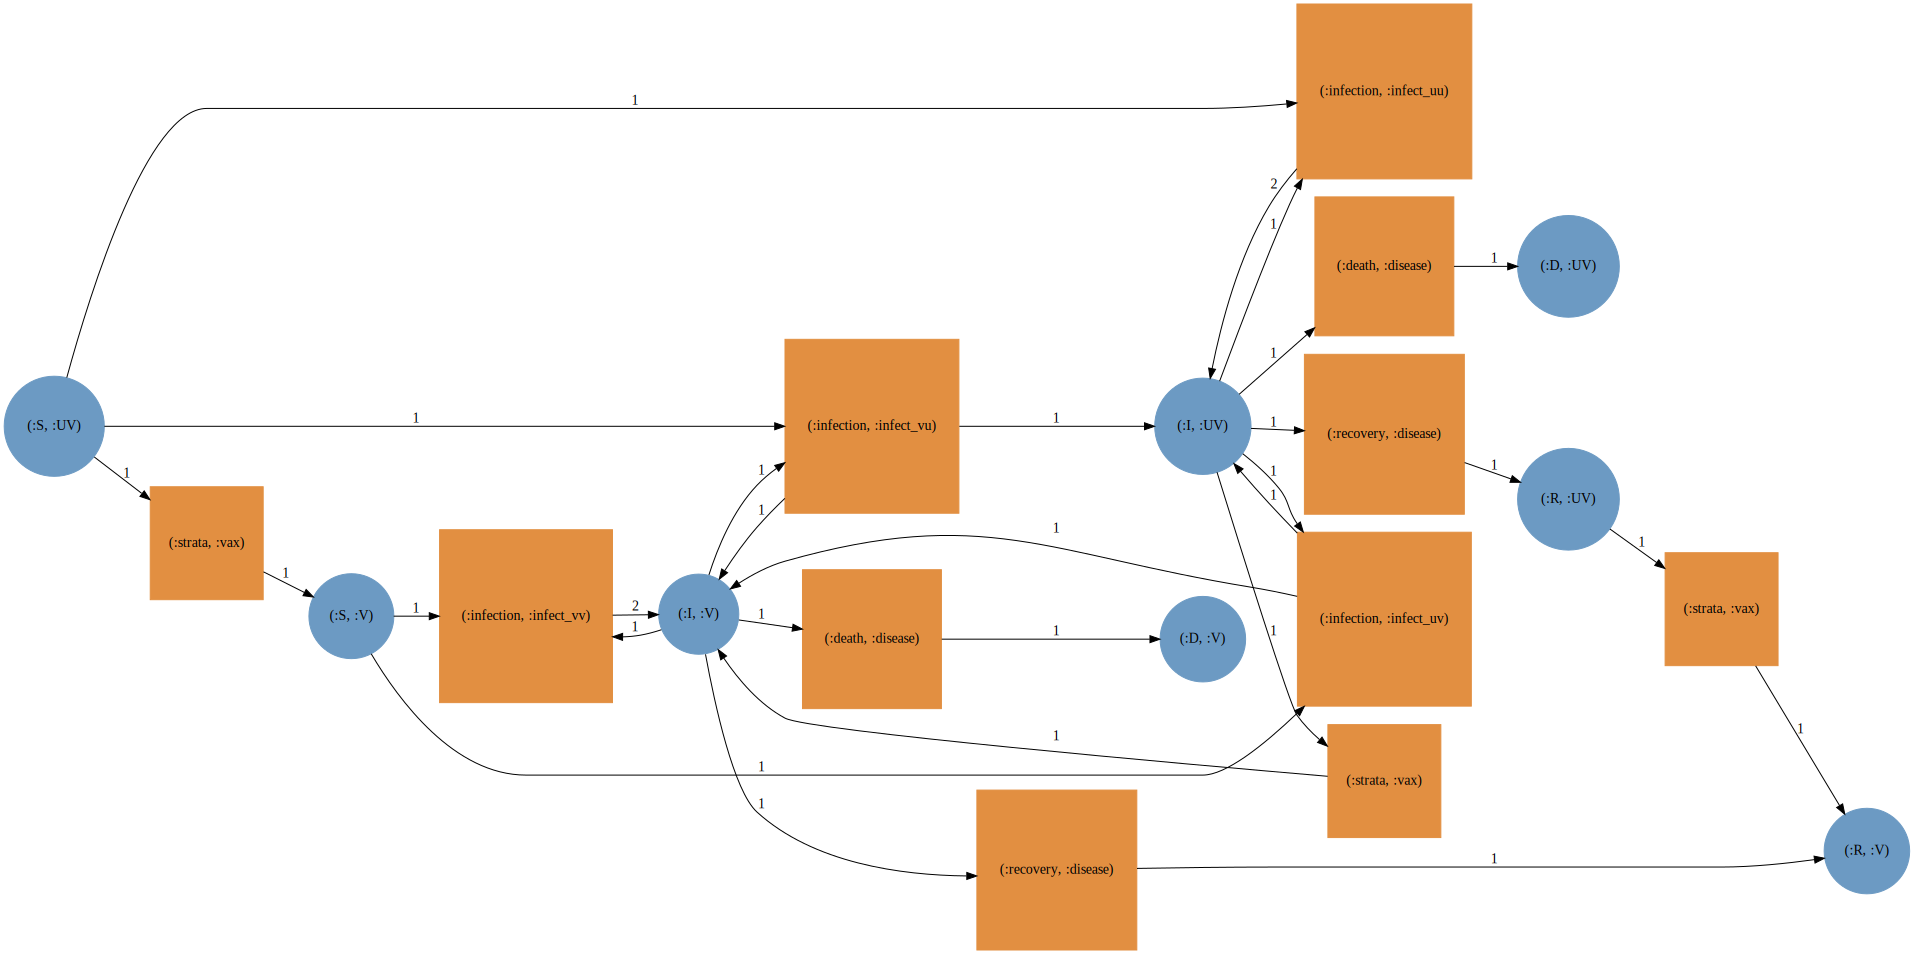

In [7]:
typed_product(sird_model, vax_model) |> dom |> to_graphviz

### Mask-Vax Model

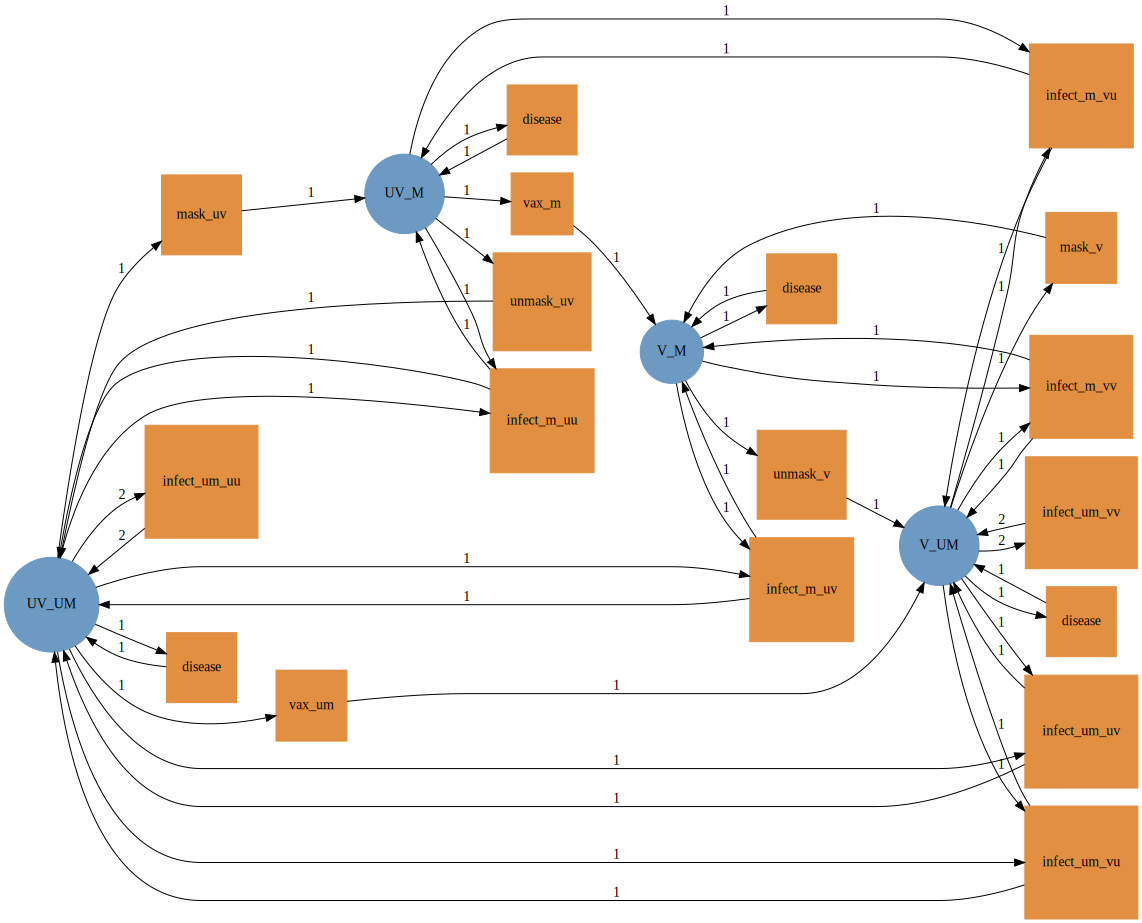

In [8]:
mask_vax_uwd = @relation (UV_UM,UV_M,V_UM,V_M) where (UV_UM::Pop, UV_M::Pop, V_UM::Pop, V_M::Pop) begin
  strata(UV_UM, UV_M)
  strata(UV_M, UV_UM)
  strata(V_UM, V_M)
  strata(V_M, V_UM)
  strata(UV_UM, V_UM)
  strata(UV_M, V_M)
  infect(V_UM, V_UM, V_UM, V_UM)
  infect(V_UM, UV_UM, V_UM, UV_UM)
  infect(UV_UM, V_UM, UV_UM, V_UM)
  infect(UV_UM, UV_UM, UV_UM, UV_UM)
  infect(V_M, V_UM, V_M, V_UM)
  infect(V_M, UV_UM, V_M, UV_UM)
  infect(UV_M, V_UM, UV_M, V_UM)
  infect(UV_M, UV_UM, UV_M, UV_UM)
end
mask_vax_model = oapply_typed(
  infectious_ontology,
  mask_vax_uwd,
  [:mask_uv, :unmask_uv, :mask_v, :unmask_v, :vax_um, :vax_m, :infect_um_vv, :infect_um_uv, :infect_um_vu, :infect_um_uu, :infect_m_vv, :infect_m_uv, :infect_m_vu, :infect_m_uu]
)
mask_vax_model = add_reflexives(mask_vax_model, [[:disease], [:disease], [:disease], [:disease]], infectious_ontology)

to_graphviz(dom(mask_vax_model))

Stratify our SIRD model on this mask + vaccine model to get a model of SIRD with a vaccination rate and masking policies:

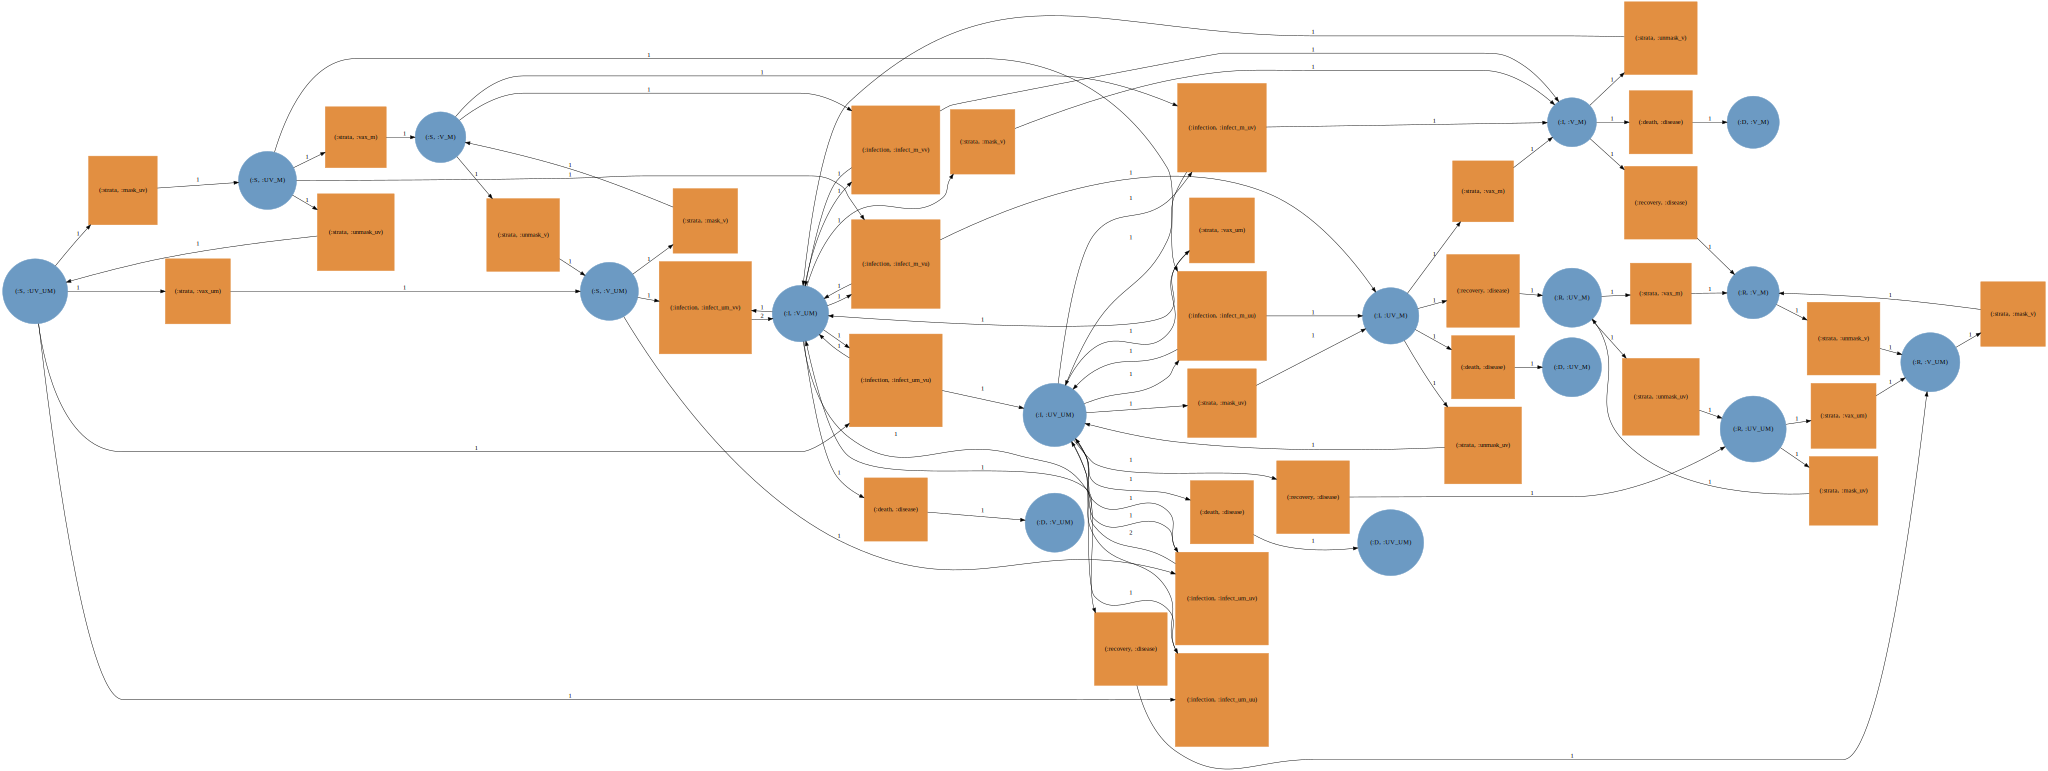

In [9]:
typed_product(sird_model, mask_vax_model) |> dom |> to_graphviz

## Define geographic models

### Travel model between $N$ regions

For this model we can use a julia function to programmatically build up our undirected wiring diagram for defining this model.
Here we want there to be $N$ regions in which people can travel between each region and people within the same region are able
to infect other people in the same region.

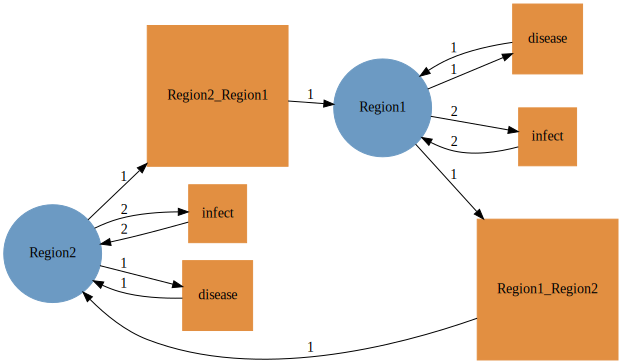

In [10]:
function travel_model(n)
  uwd = RelationDiagram(repeat([:Pop], n))
  junctions = Dict(begin
    variable = Symbol("Region$(i)")
    junction = add_junction!(uwd, :Pop, variable=variable)
    set_junction!(uwd, port, junction, outer=true)
    variable => junction
  end for (i, port) in enumerate(ports(uwd, outer=true)))

  pairs = filter(x -> first(x) != last(x), collect(Iterators.product(keys(junctions), keys(junctions))))
  for pair in pairs
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:strata)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end

  act = oapply_typed(infectious_ontology, uwd, [Symbol("$(a)_$(b)") for (a, b) in pairs])
  add_reflexives(act, repeat([[:infect, :disease]], n), infectious_ontology)
end

to_graphviz(dom(travel_model(2)))

Stratify our SIRD model on this travel model with two regions:

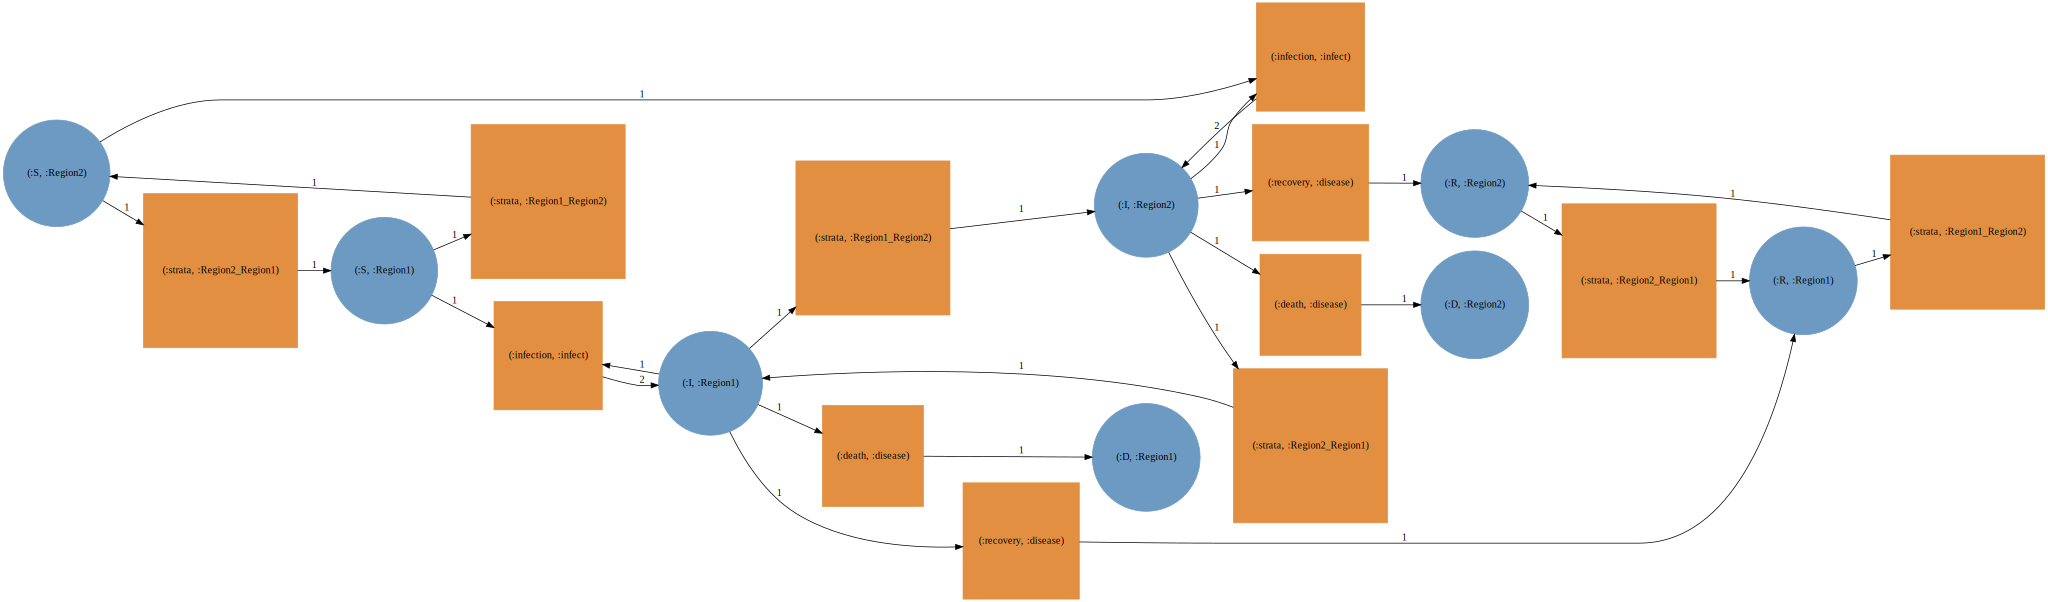

In [11]:
typed_product(sird_model, travel_model(2)) |> dom |> to_graphviz

### Simple Trip model between $N$ regions

For this model we can use a julia function to programmatically build up our model where people have the property of living somewhere
and we are modelling them travelling between locations while maintaining the status of where they live.  Here we can actually just
define the model of having a "Living" status and stratify it with the previously defined travel model to get a model of someone taking a simple trip.

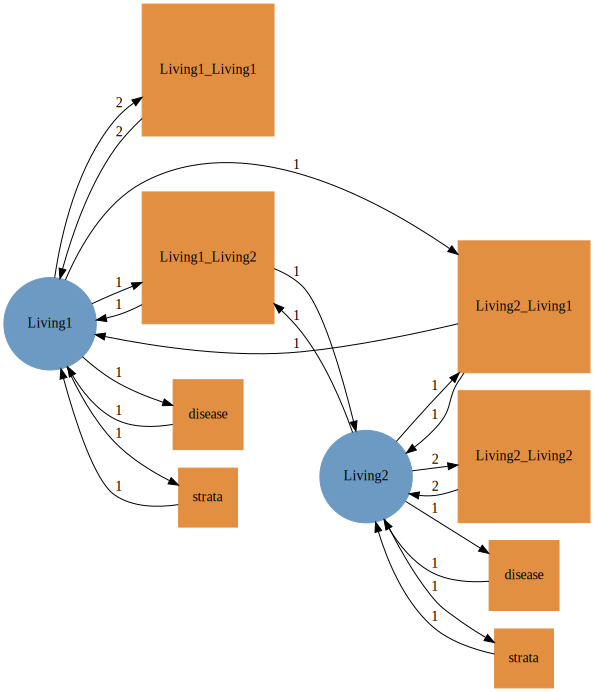

In [12]:
function living_model(n)
  typed_living = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, [Symbol("Living$(i)") for i in 1:n])
  add_reflexives(typed_living, repeat([[:disease, :strata]], n), infectious_ontology)
end

to_graphviz(dom(living_model(2)))

The resulting simple trip model:

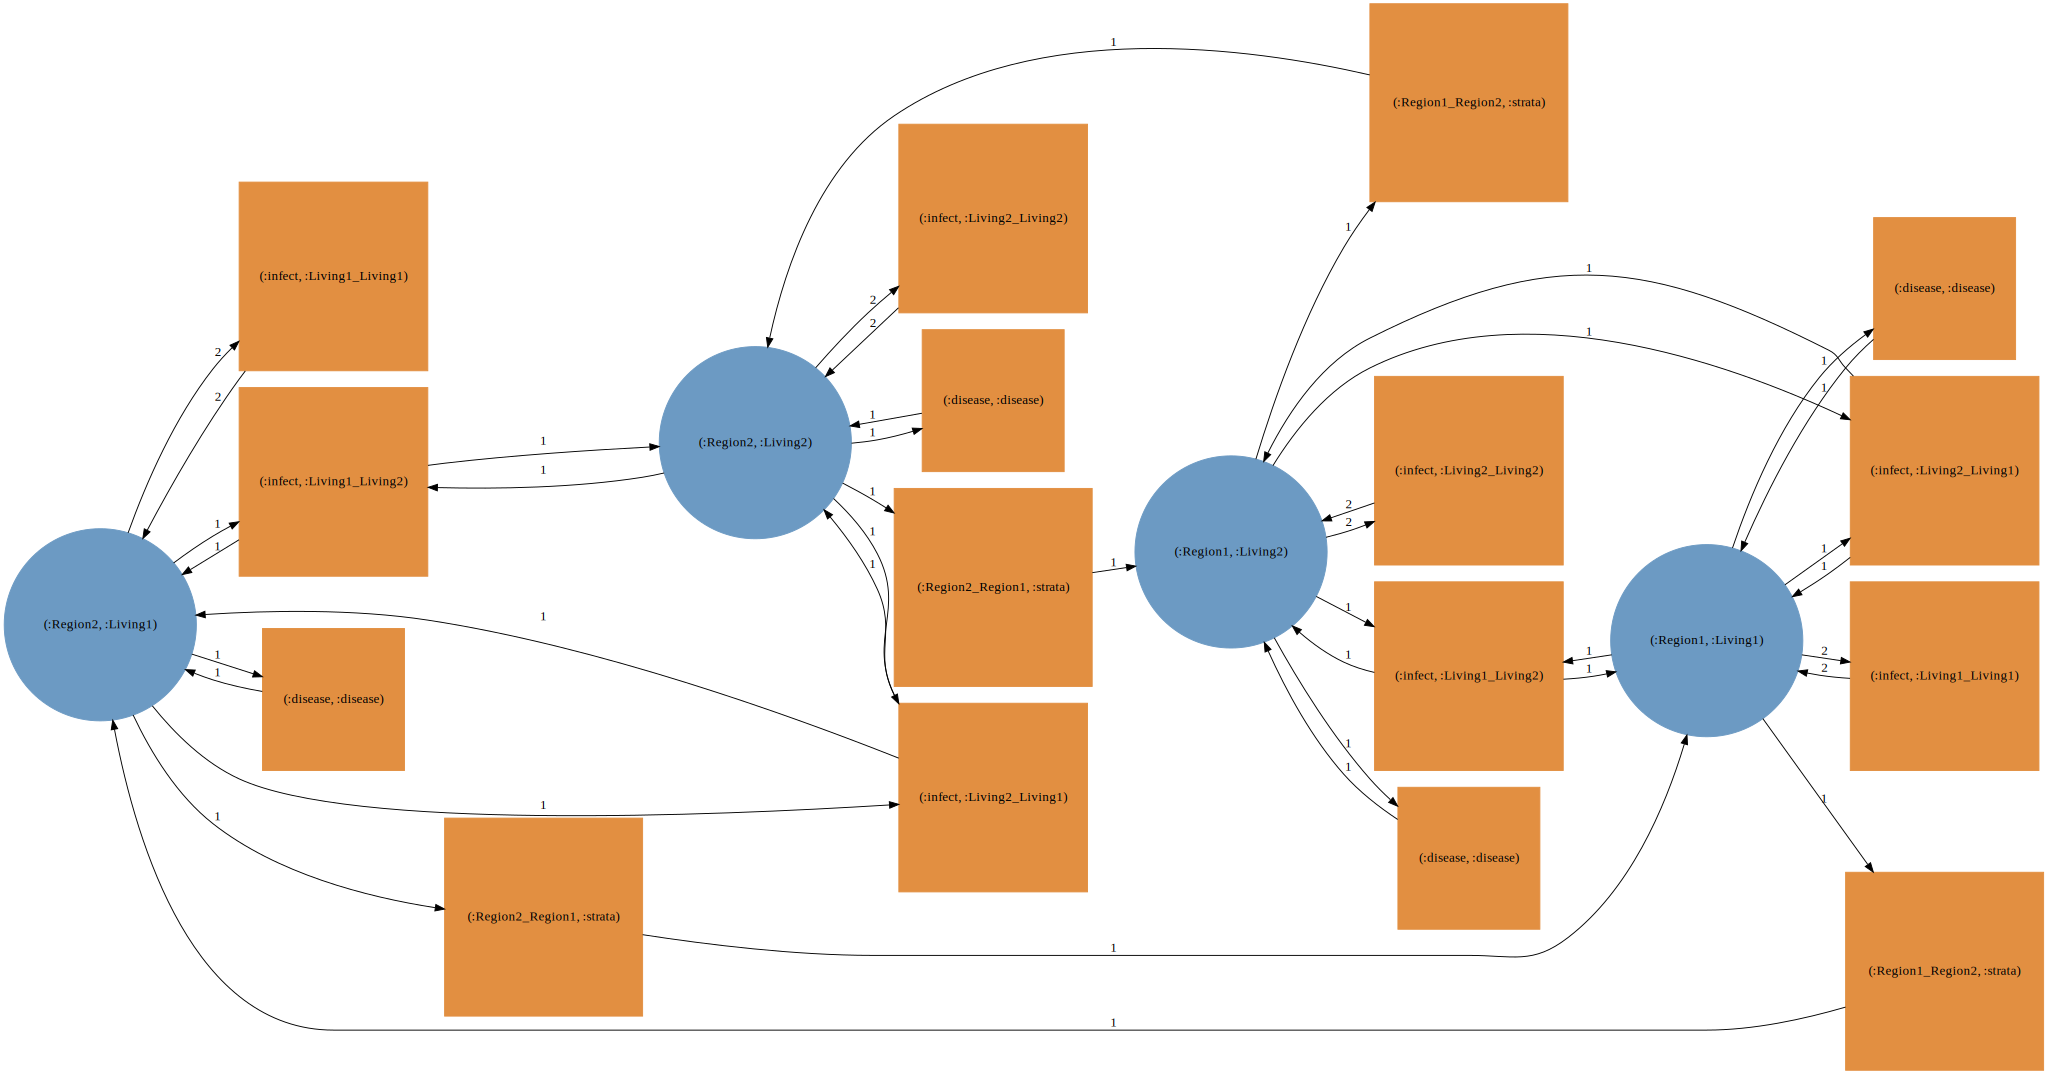

In [13]:
simple_trip_model = typed_product(travel_model(2), living_model(2))
to_graphviz(dom(simple_trip_model))

Stratify our SIRD model on this simple trip model between two regions:

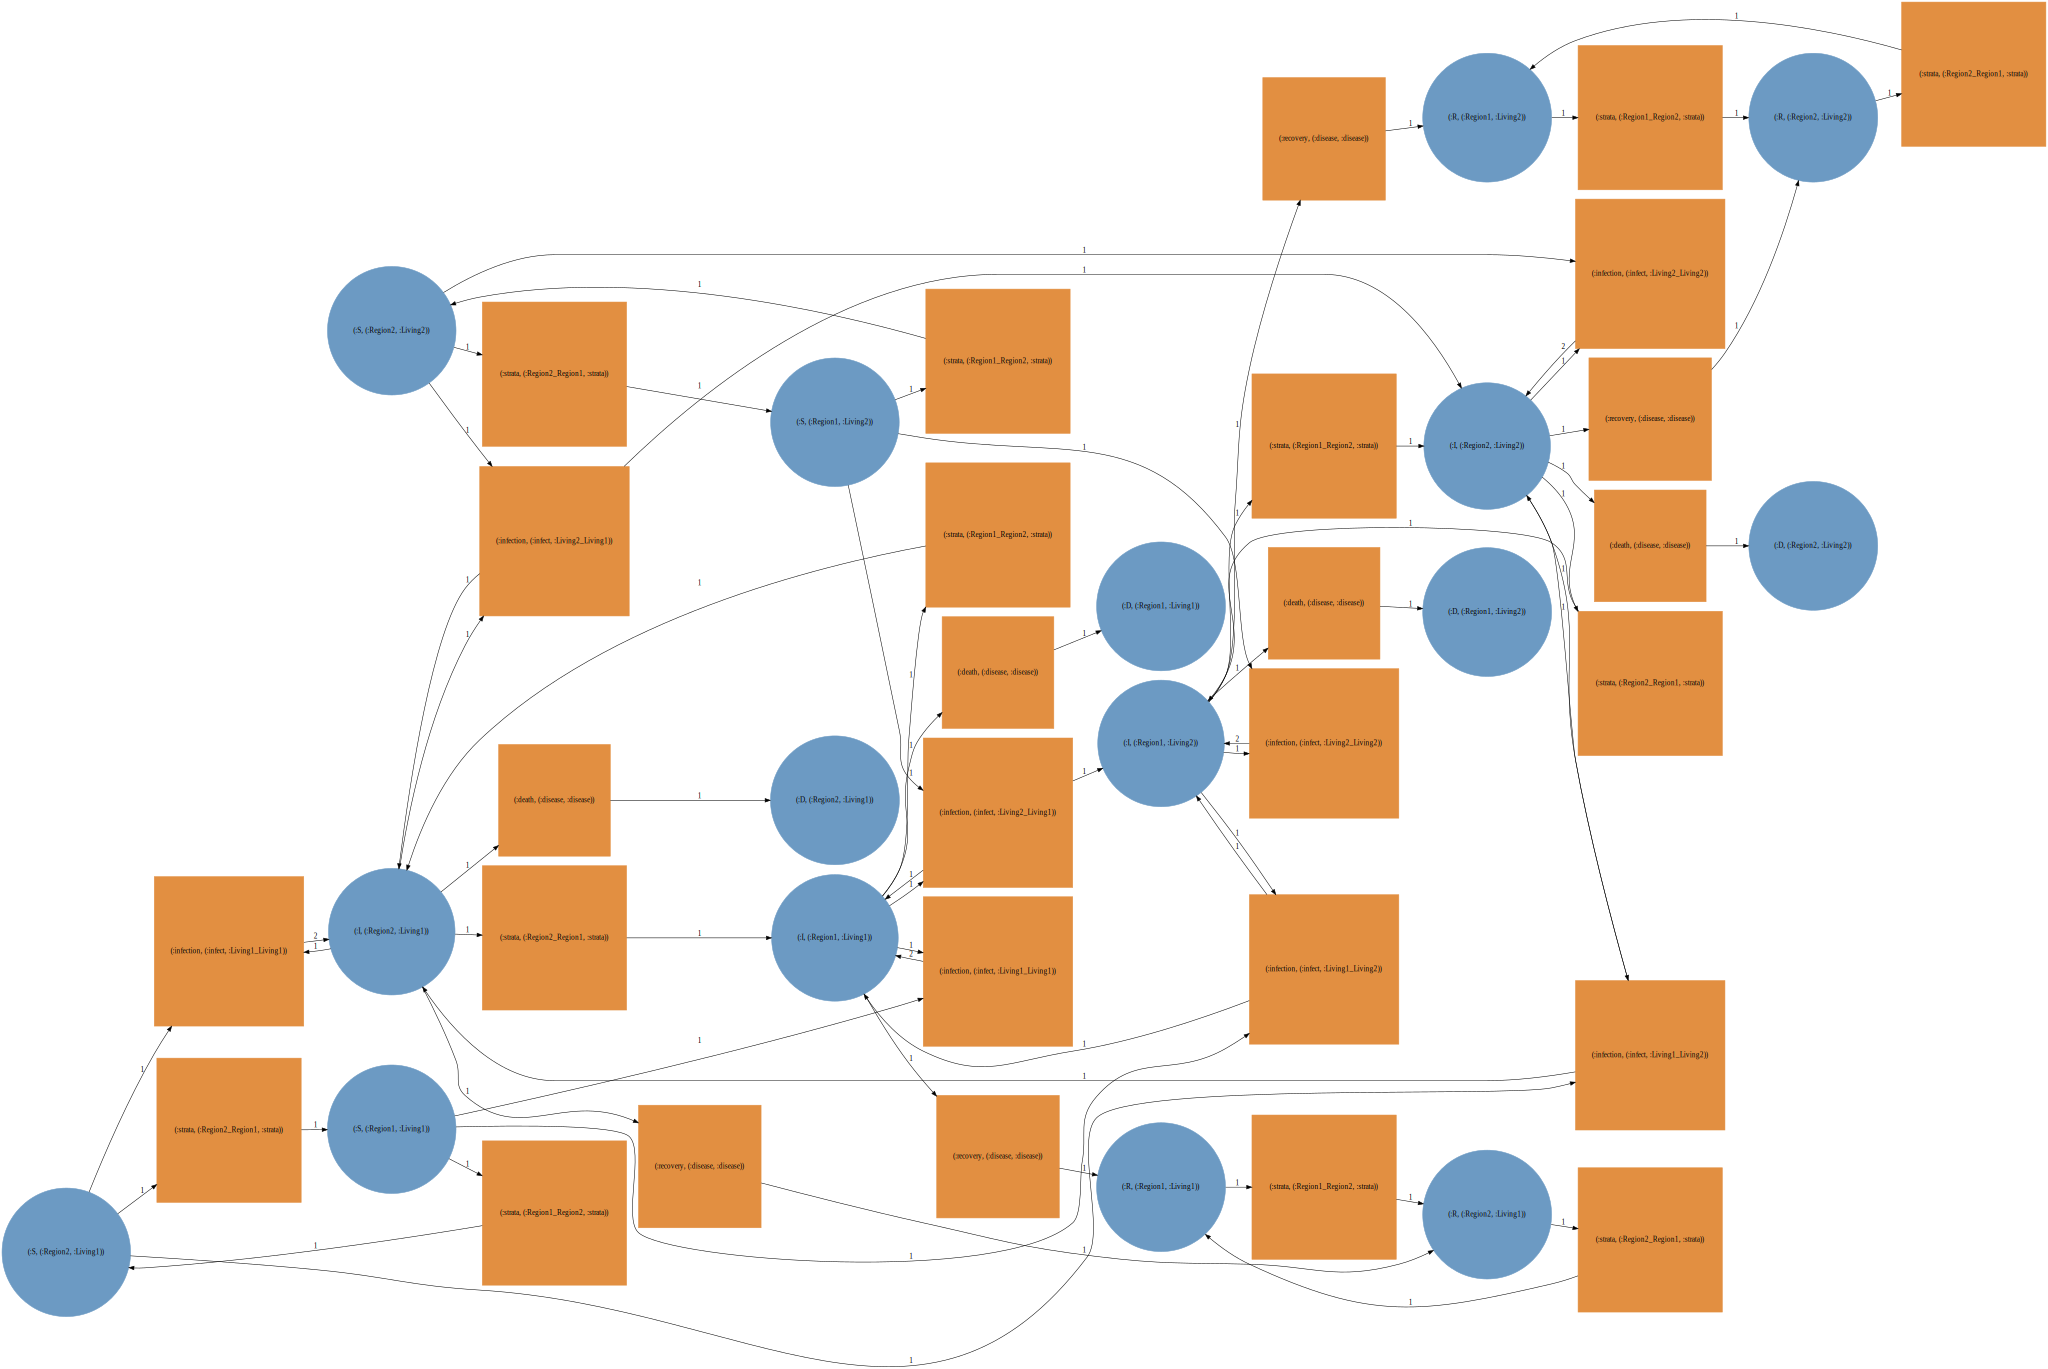

In [14]:
typed_product(sird_model, simple_trip_model) |> dom |> to_graphviz

## Stratification of COVID models

we set up a simple helper function to connect the undirected wiring diagrams to our
infectious disease type system and add the necessary reflexive transitions for stratification.

In [15]:
function oapply_mira_model(uwd)
  model = oapply_typed(infectious_ontology, uwd, [Symbol("t$(n)") for n in 1:nboxes(uwd)])
  add_reflexives(model, [repeat([[:strata]], njunctions(uwd)-3)..., [], [:strata],[]], infectious_ontology)
end

oapply_mira_model (generic function with 1 method)

### SIDARTHE Model

BIOMD0000000955_miranet

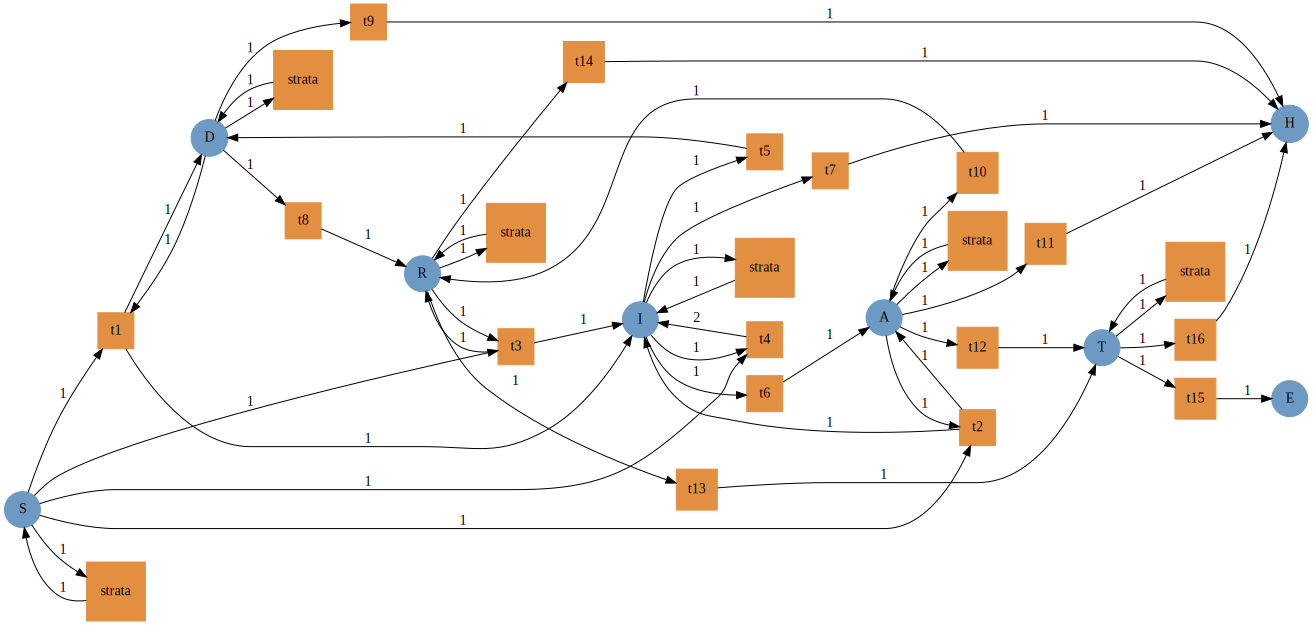

In [16]:
m1_model = (@relation (S,I,D,A,R,T,H,E) where (S::Pop, I::Pop, D::Pop, A::Pop, R::Pop, T::Pop, H::Pop, E::Pop) begin
  infect(S, D, I, D)
  infect(S, A, I, A)
  infect(S, R, I, R)
  infect(S, I, I, I)
  disease(I, D)
  disease(I, A)
  disease(I, H)
  disease(D, R)
  disease(D, H)
  disease(A, R)
  disease(A, H)
  disease(A, T)
  disease(R, T)
  disease(R, H)
  disease(T, E)
  disease(T, H)
end) |> oapply_mira_model

to_graphviz(dom(m1_model))

### SEIAHRD Model

BIOMD0000000960_miranet

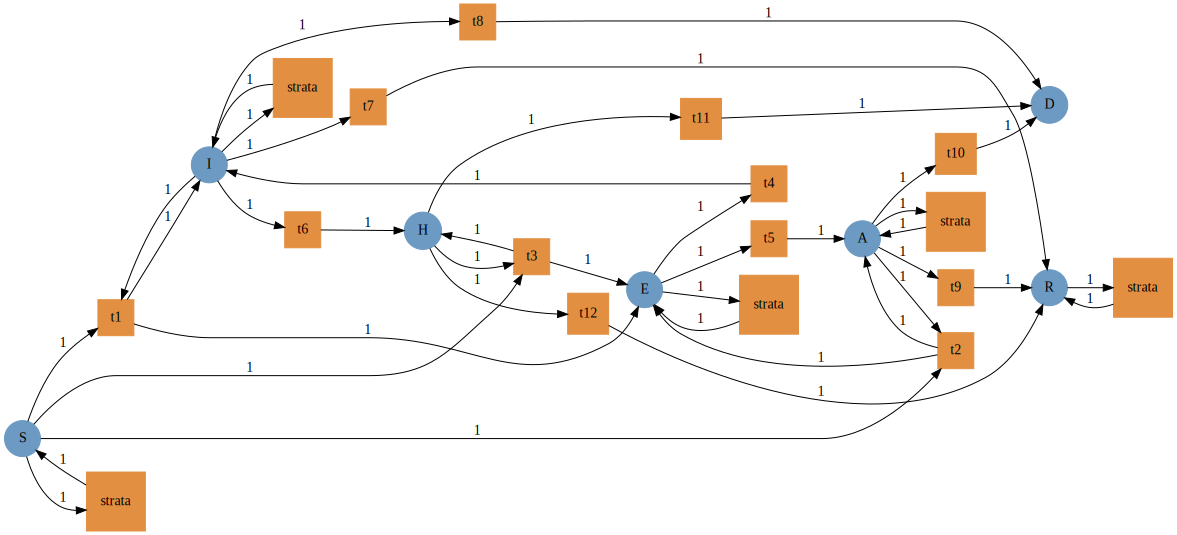

In [17]:
m2_model = (@relation (S,E,I,A,H,R,D) where (S::Pop, E::Pop, I::Pop, A::Pop, H::Pop, R::Pop, D::Pop) begin
  infect(S, I, E, I)
  infect(S, A, E, A)
  infect(S, H, E, H)
  disease(E, I)
  disease(E, A)
  disease(I, H)
  disease(I, R)
  disease(I, D)
  disease(A, R)
  disease(A, D)
  disease(H, D)
  disease(H, R)
end) |> oapply_mira_model

to_graphviz(dom(m2_model))

### SEIuIrQRD Model

BIOMD0000000983_miranet

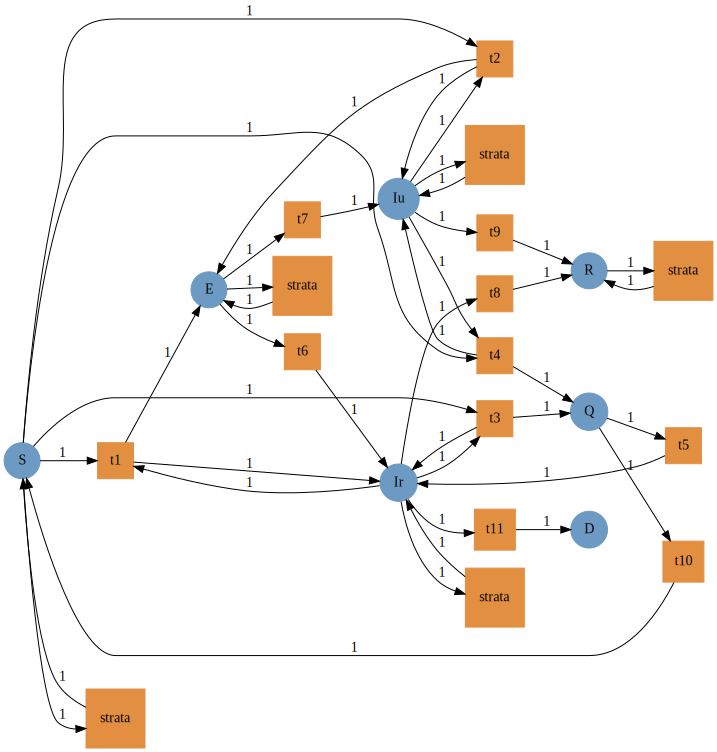

In [18]:
m3_model = (@relation (S,E,Iu,Ir,Q,R,D) where (S::Pop, E::Pop, Iu::Pop, Ir::Pop, Q::Pop, R::Pop, D::Pop) begin
  infect(S, Ir, E, Ir)
  infect(S, Iu, E, Iu)
  infect(S, Ir, Q, Ir)
  infect(S, Iu, Q, Iu)
  disease(Q, Ir)
  disease(E, Ir)
  disease(E, Iu)
  disease(Ir, R)
  disease(Iu, R)
  disease(Q, S)
  disease(Ir, D)
end) |> oapply_mira_model

to_graphviz(dom(m3_model))

### Enumerating stratified models

Next we can take all of our epidemiology, intervention, and geography models and easily enumerate
and calculate the models for every possible stratification combination and investigate the resulting models
with some set number of regions for the geographic stratification models.

In [19]:
num_rgns = 5
disease_models = [("SIRD", sird_model), ("SIDARTHE", m1_model), ("SEIAHRD", m2_model), ("SEIuIrQRD", m3_model)]
policy_models = [nothing, ("Vaccination", vax_model), ("Masking", mask_model), ("Masking + Vaccination", mask_vax_model)]
travel_models = [nothing, ("Travel", travel_model(num_rgns)), ("Simple Trip", typed_product(travel_model(num_rgns), living_model(num_rgns)))]

table = ["| Model | Intervention | Geography ($(num_rgns) regions) | # of States | # of Transitons |","|:--|$(repeat(":-:|", 4))"]

for pieces in Iterators.product(disease_models, policy_models, travel_models)
  petri = typed_product(last.(collect(filter(x -> !isnothing(x), pieces)))) |> dom
  push!(table, "|$(join([isnothing(piece) ? "N/A" : first(piece) for piece in pieces],"|"))|$(ns(petri))|$(nt(petri))|")
end

Markdown.parse(join(table, "\n")) |> DisplayAs.HTML

Model,Intervention,Geography (5 regions),# of States,# of Transitons
SIRD,N/A,N/A,4,6
SIDARTHE,N/A,N/A,8,22
SEIAHRD,N/A,N/A,7,17
SEIuIrQRD,N/A,N/A,7,16
SIRD,Vaccination,N/A,8,11
SIDARTHE,Vaccination,N/A,16,46
SEIAHRD,Vaccination,N/A,14,35
SEIuIrQRD,Vaccination,N/A,14,35
SIRD,Masking,N/A,8,12
SIDARTHE,Masking,N/A,16,44


## Performance

As we increase the number of regions in our geographic stratification models, the
number of states and transitions increase polynomially which causes the execution time
for calculating the final stratified model to also increase polynomially.

![Runtime vs. Number of Georgraphic Regions](../../assets/runtime_vs_num_rgns.svg)